In [2]:
#from ipynb.fs.full.Phase_and_Correlation_Scramble import readMRI, createCorrelationMatrix, findThreshold, phaseScramble1, binarize, calculate_small_worldness, randomizeCorrelationMatrix
import utils
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random


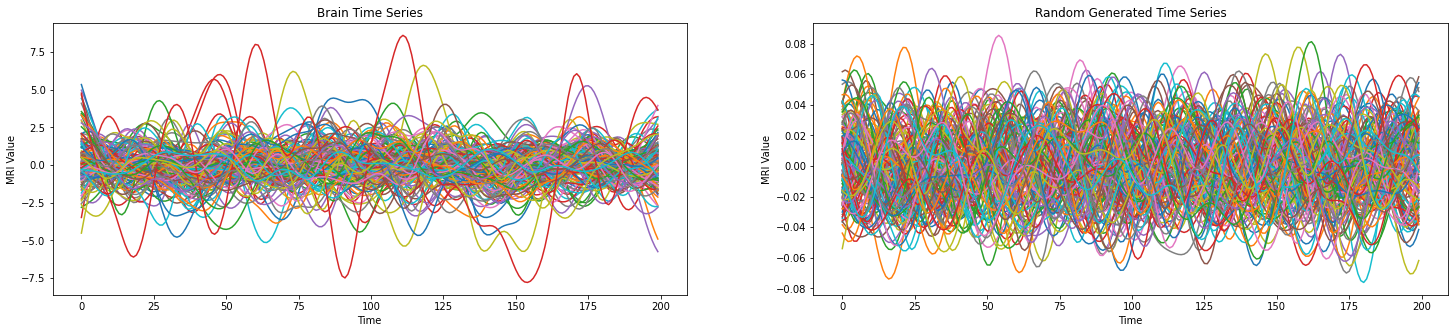

In [15]:
fig, ax = plt.subplots(nrows=1 , ncols=2, figsize=(25, 5))

#read the data that we have
x ,roi_timeseries = utils.readMRIFile('/Users/niva.ranavat/Desktop/Data/SAL_01/roi',200)
for i in roi_timeseries:
    ax[0].plot(x,i)
    ax[0].set_title("Brain Time Series")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("MRI Value")
    
var = np.var(roi_timeseries,axis = 1)
#print("Variance: ", var)

#create correlation matrix
brain_correlationMatrix = utils.createCorrelationMatrix(roi_timeseries,"pearson") - np.identity(150)





#create random time series similar with a mean of 0 and a variance of about var
#do the same process as we did with the brain
#sigma * np.random.randn(...) + mu
#the signals need to each fall within aa frequency range 0.01 to 0.1


#functions taken from https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

mu = 0
sigma = 1
random_timeseries = [band_limited_noise(0.01, 0.1, 200,2) for i in range(150)]

#random_timeseries = np.random.normal(loc = 0.05, scale = 1, size = (150,200))  #this will be any value need to make it in range -1 to 1
#maxs = np.max(np.vstack((np.absolute(np.max(random_timeseries,axis=1)), np.absolute(np.min(random_timeseries,axis=1)))),axis = 0)

# random_timeseries = var * np.random.randn(200,150) + mu 
# random_timeseries = random_timeseries.T

#print(maxs.shape,random_timeseries.shape)

for i in range(len(random_timeseries)):
    #random_timeseries[i] = random_timeseries[i]/maxs[i]
    
    ax[1].plot(x,random_timeseries[i])
    ax[1].set_title("Random Generated Time Series")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("MRI Value")

plt.show() #display our time series that was randomly generated along with the observed brain


In [16]:
#run the process over 20 iterations and a range of thresholds

#create correlation matrix
random_correlationMatrix = utils.createCorrelationMatrix(random_timeseries,"pearson") - np.identity(150)
ccoef  = [] #clustering coefficient
path_length = [] #path length
sw = [] #small worldness

#take a threshold range
threshold_range = np.arange(0.03,0.35,0.02)
#randomize it 20 times for each threshold/density
for i in threshold_range:
    
    c = []
    p = []
    s = []
    
    #get the brain "Observed" binarzied
    brain_threshold = utils.findThreshold(brain_correlationMatrix, i)
    brain_binaryMatrix = utils.binarize(brain_correlationMatrix, brain_threshold)
    
    #find the threshold
    random_threshold = utils.findThreshold(random_correlationMatrix,i)
    print(i, "brain: ", brain_threshold, "random: ",random_threshold)
    
    for j in range(20):
    

        #binarize the correlation matrix
        random_binaryMatrix = utils.binarize(random_correlationMatrix, random_threshold)
        
        small_worldness, normalized_ccoef, normalized_path_length = utils.calculate_small_worldness(brain_binaryMatrix, random_binaryMatrix)
        c.append(normalized_ccoef)
        p.append(normalized_path_length)
        s.append(small_worldness)

        #unsure on how the matrix was randomly rewired
        #shuffling the correlation matrix
        random_correlationMatrix = utils.randomizeCorrelationMatrix(random_correlationMatrix)
    
    ccoef.append(np.average(c))
    path_length.append(np.average(p))
    sw.append(np.average(s))

    


0.03 brain:  0.5114016248240133 random:  0.4200739538927807


/opt/anaconda3/lib/python3.7/statistics.py:355: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))
/Users/niva.ranavat/UCI Research/utils.py:297: RuntimeWarning: invalid value encountered in double_scalars
  else: path_length_ratio = observed_path_length/randomized_path_length


0.05 brain:  0.4509635838382326 random:  0.36840544083675675
0.07 brain:  0.40993469171652985 random:  0.32743568373883414
0.09000000000000001 brain:  0.3809644235155035 random:  0.2982369372942837
0.11000000000000001 brain:  0.3515410461480166 random:  0.27391275464577874
0.13 brain:  0.32450389804304997 random:  0.2517745022573108
0.15000000000000002 brain:  0.29870990789997254 random:  0.23302809212950898
0.17 brain:  0.2800270078466055 random:  0.2151109419165249
0.19000000000000003 brain:  0.259921020219489 random:  0.19868717622808946
0.21000000000000005 brain:  0.24180534151727268 random:  0.18231130333071544
0.23000000000000004 brain:  0.22341087064272813 random:  0.1666354179325159
0.25 brain:  0.2041267239526977 random:  0.15229896718856362
0.27 brain:  0.18565900226807266 random:  0.13879358714819867
0.29000000000000004 brain:  0.17055352243026028 random:  0.12437765527294625
0.31000000000000005 brain:  0.1535461273126308 random:  0.11057000548175161
0.33000000000000007 brai

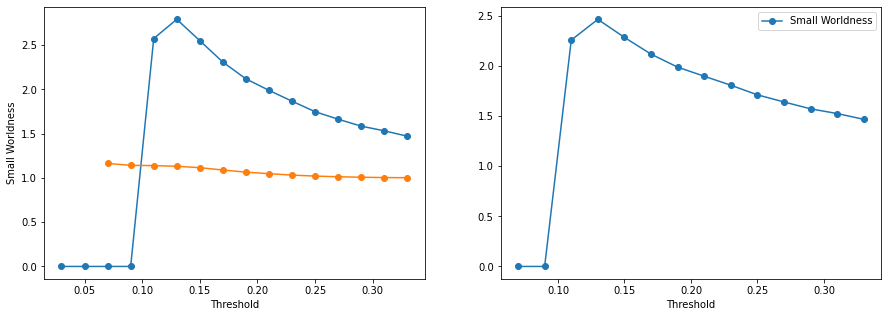

In [17]:
#plot out the figure from the above cell that was calculated
fig, ax = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))

ax[0].plot(threshold_range,ccoef,label="Clustering Coefficient",marker='o')
ax[0].plot(threshold_range,path_length,label="Path Length",marker='o')
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Normalized Network Measure")
ax[1].plot(threshold_range,sw,label="Small Worldness",marker='o')
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Small Worldness")
plt.legend()
plt.show()